In [ ]:
!pip install -U folium
!pip install -U branca
!pip install geopandas

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re
import requests
import json
import folium
import shapely 
import random
import warnings
import scipy
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv("/project/shanti_data/data.csv")

In [ ]:
data.columns

In [3]:
data.rename(columns={'S_Lat': 'Latitude', 'S_Long':'Longitude'}, inplace=True)

In [4]:
data.drop(['Unnamed: 0'],
             axis=1, inplace=True)

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

Text(0.5, 80.7222222222222, 'Longitude')

Text(143.91233936591485, 0.5, 'Latitude')

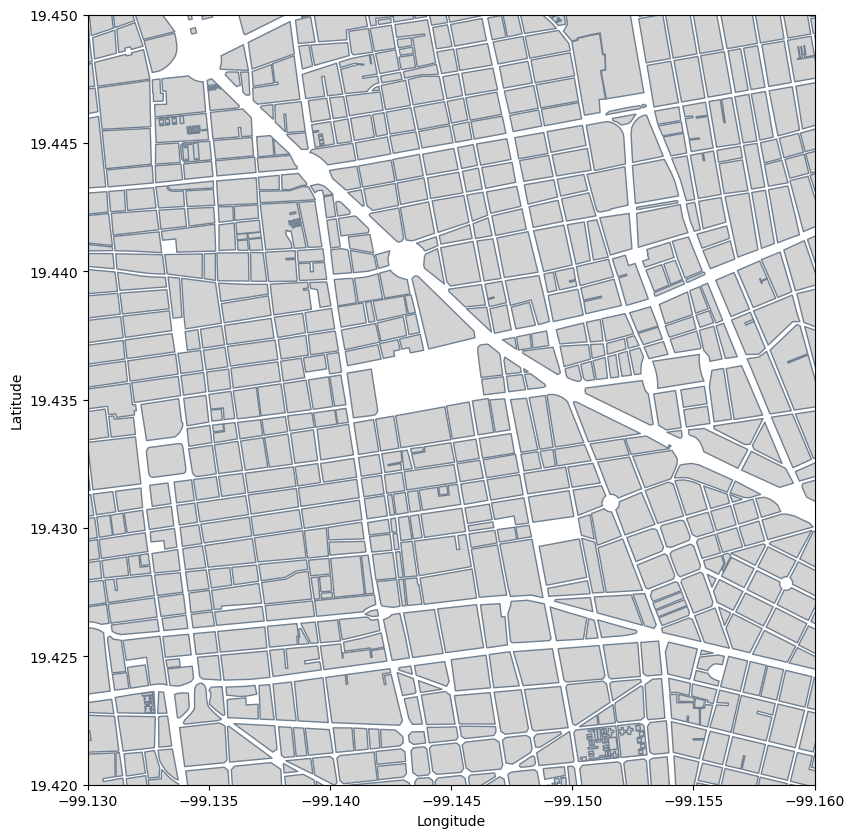

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
blocks = gpd.read_file('/project/blocks/poligono_manzanas_cdmx.shp')
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey');

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('/project/pictures/blocks.png', bbox_inches='tight')

In [6]:
blocks.set_crs("EPSG:4326", inplace=True);

In [8]:
from shapely.geometry import Point
# Create a GeoDataFrame from your existing DataFrame
data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Set the coordinate reference system (CRS) to be the same as the blocks
# This is necessary for the spatial join to work correctly
gdf.set_crs(blocks.crs, inplace=True)

# Perform the spatial join
joined = gpd.sjoin(gdf, blocks, how='left', op='intersects');

# The result is a new GeoDataFrame that includes all columns from the original DataFrame,
# plus additional columns for each attribute in the shapefile for the block that each point falls within.

In [ ]:
joined.head(3)

In [8]:
joined= joined.drop(['Latitude','Longitude','Name of Business','Pictures','Business Owner',
                    'District','Neighborhood','CVEGEO','CVE_ENT','CVE_MUN',
                     'CVE_LOC','CVE_AGEB','CVE_MZA','AMBITO','TIPOMZA'], axis=1)

In [9]:
joined=joined.drop_duplicates(keep='first')

In [ ]:
joined.shape

## Zoom into the Downtown 

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')


ax.set_xlim([-99.10, -99.20])
ax.set_ylim([19.4, 19.5])

plt.show()


## Zoom in more

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the points
gdf.plot(ax=ax, color='red')

plt.show()



In [ ]:
gdf.geometry.is_valid.count

In [ ]:
print(joined['index_right'].isna().sum())
print(joined['index_right'].count())

In [ ]:
unmatched = joined[joined['index_right'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
unmatched.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()



Since the points are falling on the streets and not within the blocks, we will use a buffer around the points to include a surrounding area, which may intersect with the blocks. This can help accommodate points that fall on the streets but are still functionally "within" a block. The currentcoordinate system EPSG:4326, which uses degrees as its unit. This is not the most intuitive approach when trying to create a buffer. We will convert to Universal Transverse Mercator which uses meters instead of degrees. The UTM Zone for Mexico City is EPSG code 32614.

In [ ]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf1 = gpd.GeoDataFrame(data, geometry='geometry')
gdf1 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf1['geometry'] = gdf1.geometry.buffer(5) # 5 meters as buffer size

# Re-do the spatial join
joined1 = gpd.sjoin(gdf1, blocks, how='left', op='intersects')


Let's compare NaN values and plot again.

In [ ]:
print(joined1['index_right'].isna().sum())
print(joined1['index_right'].count())

In [ ]:
blocks = blocks.to_crs(epsg=4326)


unmatched1 = joined1[joined1['index_right'].isna()]
unmatched1 = unmatched1.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
unmatched1.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()

We can see that there are few points that are not matched to a block. We will do the join again with a buffer size of 15 meters to assign points on streets to blocks. However, if there are unmatched points after buffer=15, we will not increase the buffer size any further. This is because if the buffer size is too large then points may be assigned to multiple blocks, which would introduce bias into our analysis later on.

In [9]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf2 = gpd.GeoDataFrame(data, geometry='geometry')
gdf2 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf2['geometry'] = gdf2.geometry.buffer(15) # 15 meters as buffer size

# Re-do the spatial join
joined2 = gpd.sjoin(gdf2, blocks, how='left', op='intersects')

In [10]:
print(joined2['index_right'].isna().sum())
print(joined2['index_right'].count())

21
4987


We can see that the ratio of unmatched points to matched points is only 0.004, which is an acceptable degree.

In [12]:
unmatched_count = joined2['index_right'].isna().sum()
matched_count = joined2['index_right'].count()

# Calculate ratio
ratio = unmatched_count / matched_count

print(f"Ratio of unmatched points to matched points: {ratio}")


Ratio of unmatched points to matched points: 0.00421094846601163


<AxesSubplot:>

<AxesSubplot:>

(-99.14, -99.155)

(19.435, 19.443)

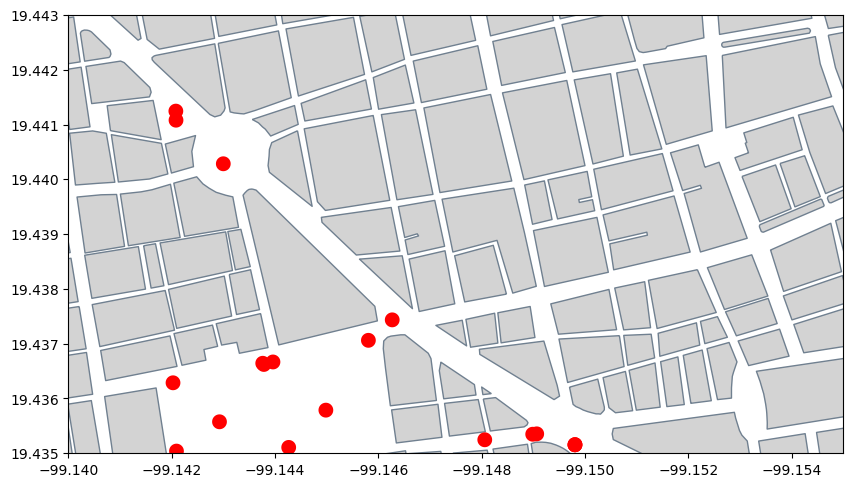

In [13]:
blocks = blocks.to_crs(epsg=4326)


unmatched2 = joined2[joined2['index_right'].isna()]
unmatched2 = unmatched2.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
unmatched2.plot(ax=ax, color='red')
ax.set_xlim([-99.140, -99.155])
ax.set_ylim([19.435, 19.443])
plt.show()

## Processing Joined 2

In [11]:
joined2= joined2.drop(['Latitude','Longitude','Name of Business','Pictures','Business Owner',
                    'District','Neighborhood','CVEGEO','CVE_ENT','CVE_MUN',
                     'CVE_LOC','CVE_AGEB','CVE_MZA','AMBITO','TIPOMZA','Time Open',
                       'Time Close','index_right'], axis=1)

In [12]:
joined2=joined2.drop_duplicates(keep='first')

In [14]:
joined2.columns

Index(['Storefront', 'Visible Sign of Business', 'Business WiFi',
       'Business tables', 'Business Plugs', 'Business Internal CCTV',
       'External CCTV', 'Number of female employees', 'Accepts credit card',
       'Incline', 'Width', 'Ramp conditions', 'Ramp // Crosswalk',
       'Ramp obstacles', 'Crosswalk width', 'Vertical signs',
       'Crossing length', 'Access to people with disabilities',
       'Pedestrian strip width', 'Strip services', 'Material',
       'Status of maintenance', 'Continuity', 'Temporary obstacles',
       'Permanent obstacles', 'Street obstacles', 'Benches', 'Trees',
       'Planters', 'Commerciality', 'Percentage of parking accesses',
       'Facade Visibility', 'Broken public property', 'Incivility',
       'Obstacles', 'Physical aspects in poor condition',
       'Poor infrastructure', 'Positive elements', 'Broken drain-cover',
       'Drug addicts', 'Federal Judiciary', 'Panic button', 'Vandalism',
       'graffiti', 'homelessness', 'inclined ramp'

In [15]:
grouped_shanti = joined2.groupby('geometry').mean()

In [17]:
grouped_shanti.shape

(467, 61)

In [18]:
grouped_shanti.to_csv('grouped_shanti.csv')

We will remove rows where all columns apart from the 'geometry' column are identical. We do this so that the same point is not included in multiple blocks.

In [16]:
cols_to_check = joined2.columns.difference(['geometry'])
joined2 = joined2.drop_duplicates(subset=cols_to_check, keep='first')


In [ ]:
joined2.head(3)

In [ ]:
joined2.shape

# Join with WiFi Access Points

In [17]:
WiFi= pd.read_csv('/project/WiFi/wifi_access_points.csv')

In [ ]:
WiFi.head(3)

We only need the latitudes and longitudes from this dataset, so we will drop all other columns.

In [18]:
WiFi.drop(['id','programa','fecha_instalacion','colonia','alcaldia'],
             axis=1, inplace=True)

We will now create a new DataFrame for unique combinations of latitude and longitude to count how many WiFi points there are for each coordinate.

In [19]:
WiFi_counts = WiFi.groupby(['latitud', 'longitud']).size().reset_index(name='WiFi')
WiFi_counts.head(2)

,latitud,longitud,WiFi
0,19.12339,-99.18389,1
1,19.13010,-99.18,1


In [20]:
WiFi_counts.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude'}, inplace=True)

In [ ]:
WiFi_counts.head(3)

We will clean up the coordinates by removing spaces and other non-digit, non-dot characters, converting them into float type.

In [21]:
def clean_coordinate(coord):
    # Check if it is a negative number
    if str(coord).strip().startswith('-'):
        is_negative = True
    else:
        is_negative = False

    # Keep only digits and dots
    cleaned = ''.join(ch for ch in str(coord) if ch.isdigit() or ch == '.')

    # Convert to float
    try:
        if is_negative:
            return -float(cleaned)
        else:
            return float(cleaned)
    except ValueError:
        # Return NaN if the conversion fails
        return np.nan




In [22]:
WiFi_counts['Latitude'] = WiFi_counts['Latitude'].apply(clean_coordinate)
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(clean_coordinate)


In [ ]:
WiFi_counts.head()

In [23]:
def make_negative(number):
    return -abs(number)


In [24]:
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(make_negative)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Use the 'WiFi' column for point sizes
sc = ax.scatter(WiFi_counts['Longitude'], WiFi_counts['Latitude'], 
                s=WiFi_counts['WiFi']*50, # Set size to number of WiFi access points (scaled by 10)
                color='blue', # Set color to blue
                alpha=0.6) # Set dots to be semi-transparent

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])
# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/wifi.png', bbox_inches='tight')


For the WiFi points we use a larger buffer size as the data is not as granular, as WiFi access points have a wide range where they provide access to.

In [25]:
# Convert the CRS of your geodataframes to EPSG:32614
WiFi_counts['geometry'] = WiFi_counts.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_wifi = gpd.GeoDataFrame(WiFi_counts, geometry='geometry', crs="EPSG:4326")
gdf_wifi = gdf_wifi.to_crs(epsg=32614)
joined2 = joined2.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_wifi['geometry'] = gdf_wifi.geometry.buffer(60) # 60 meters as buffer size

# Re-do the spatial join
joined_wifi = gpd.sjoin(joined2,gdf_wifi, how='left', op='intersects')

In [ ]:
joined_wifi.head()

In [ ]:
gdf_wifi.head()

In [ ]:
unmatched_wifi = joined_wifi[joined_wifi['index_right'].isna()]
unmatched_wifi = unmatched_wifi.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)

blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')
# Plot the unmatched points
unmatched_wifi.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.show()


In [ ]:
print(joined_wifi['index_right'].isna().sum())
print(joined_wifi['index_right'].count())

We will now remove duplicate rows.

In [26]:
cols_to_check_wifi = joined_wifi.columns.difference(['geometry'])
joined_wifi = joined_wifi.drop_duplicates(subset=cols_to_check_wifi, keep='first')

In [ ]:
joined_wifi.head(3)

We also don't need the exact coordinates of the wifi access points, hence we will drop these columns.

In [27]:
joined_wifi.rename(columns={'Latitude_left': 'Latitude', 'Longitude_left':'Longitude',
                           'WiFi':'Public WiFi'}, inplace=True)

In [28]:
joined_wifi.drop(['index_right','Latitude','Longitude'],
             axis=1, inplace=True)

# Join with Electric Bike Points

In [29]:
bikes = pd.read_csv('/project/bikes/electrict_bike_points.csv')

In [ ]:
bikes.head(3)

In [ ]:
bikes['colonia'].unique()

We will only keep the DownTown Mexico City as our area, as the base dataframe only includes data for this area.

In [30]:
bikes = bikes[bikes['colonia'] == 'Centro']


We only need the coordinates and the number of bike stations (locks) for each location. Therefore we will drop the other columns.

In [31]:
bikes.drop(['sistema','num_cicloestacion','nombre','calle_principal','calle_secundaria',
            'colonia','alcaldia','tipo_ce'],
             axis=1, inplace=True)

We will then clean the coordinates.

In [32]:
bikes.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude','candados': 'number of bikes'}, inplace=True)

In [33]:
bikes['Latitude'] = bikes['Latitude'].apply(clean_coordinate)
bikes['Longitude'] = bikes['Longitude'].apply(clean_coordinate)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')
# Use the 'number of bikes' column for color gradient
sc = ax.scatter(bikes['Longitude'], bikes['Latitude'], 
                s=bikes['number of bikes'], # Set size to number of bikes
                c=bikes['number of bikes'], # Use number of bikes for color
                cmap='bwr', # Set color map to a gradient from Yellow to Orange to Red
                alpha=0.6) # Set dots to be semi-transparent



# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.155, -99.13])
ax.set_ylim([19.425, 19.44])
# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar for the scatterplot
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label('Number of bikes')

plt.savefig('/project/pictures/ebike.png', bbox_inches='tight')




In [34]:
# Convert the CRS of your geodataframes to EPSG:32614
bikes['geometry'] = bikes.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_bikes = gpd.GeoDataFrame(bikes, geometry='geometry', crs="EPSG:4326")
gdf_bikes = gdf_bikes.to_crs(epsg=32614)
joined_wifi = joined_wifi.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_bikes['geometry'] = gdf_bikes.geometry.buffer(60) # 60 meters as buffer size

# Do the spatial join
joined_bikes = gpd.sjoin(joined_wifi,gdf_bikes, how='left', op='intersects')

The number of stations that have not been joined is high, however this makes sense as the number of bike stations are expected to be considerably less than the other factors we have in the data.

In [ ]:
print(joined_bikes['index_right'].isna().sum())
print(joined_bikes['index_right'].count())

In [ ]:
unmatched_bike = joined_bikes[joined_bikes['index_right'].isna()]
unmatched_bike = unmatched_bike.to_crs(epsg=4326)

matched_bike = joined_bikes[joined_bikes['index_right'].notna()]
matched_bike = matched_bike.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
#unmatched_bike.plot(ax=ax, color='red')

# Plot the matched points
matched_bike.plot(ax=ax, color='green',edgecolor='blue')

ax.set_xlim([-99.135, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Bike Access Points')
plt.show()
plt.savefig('/project/pictures/joined_bikes.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
#unmatched_bike.plot(ax=ax, color='red')

joined_bikes.plot(column='number of bikes',cmap='YlOrRd', ax=ax, 
                           linewidth=0.8, edgecolor='0.8')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                           norm=plt.Normalize(vmin=joined_bikes['number of bikes'].min(), 
                                              vmax=joined_bikes['number of bikes'].max()))
cbar = fig.colorbar(sm, cax=cax)
ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Bike Access Points')
plt.show()
plt.savefig('/project/pictures/joined_bikes.png', bbox_inches='tight')

We will now remove duplicate columns.

In [35]:
cols_to_check_bikes = joined_bikes.columns.difference(['geometry'])
joined_bikes = joined_bikes.drop_duplicates(subset=cols_to_check_bikes, keep='first')

In [ ]:
joined_bikes.head()

In [36]:
joined_bikes.rename(columns={'Latitude_left': 'Latitude', 'Longitude_left':'Longitude'}, inplace=True)

In [37]:
joined_bikes.drop(['index_right','Latitude','Longitude'],
             axis=1, inplace=True)

# Join with Inhabitants

In [38]:
inhabitants = gpd.read_file('/project/inhabitants/us_8.shp')

In [ ]:
inhabitants.tail(20)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np

# assuming inhabitants is a GeoDataFrame, if not, load it as one
# inhabitants = gpd.read_file('path_to_your_shapefile.shp')

inhabitants = inhabitants.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the inhabitants with a color map from yellow to red
inhabitants.plot(column='MEAN_HACIN', alpha=0.8,
                 cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/inhabitants.png', bbox_inches='tight')





In [39]:
inhabitants.drop(['cve_ent','alcaldia','cve_col','colonia','C_HACINAM','ID'],
             axis=1, inplace=True)

In [ ]:
inhabitants.head()

In [40]:
joined_bikes = joined_bikes.to_crs(epsg=32614)
inhabitants= inhabitants.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
inhabitants['geometry'] = inhabitants.geometry.buffer(30) # 30 meters as buffer size

# Re-do the spatial join
joined_inhabitants = gpd.sjoin(joined_bikes,inhabitants, how='left', op='intersects')

In [ ]:
print(joined_inhabitants['index_right'].isna().sum())
print(joined_inhabitants['index_right'].count())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
joined_inhabitants = joined_inhabitants.to_crs(epsg=4326)
# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')


sc=joined_inhabitants.plot(column='MEAN_HACIN', cmap='YlOrRd', ax=ax, 
                           linewidth=0.8, edgecolor='0.8')

ax.set_xlim([-99.13, -99.155])
ax.set_ylim([19.425, 19.443])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                           norm=plt.Normalize(vmin=joined_inhabitants['MEAN_HACIN'].min(), 
                                              vmax=joined_inhabitants['MEAN_HACIN'].max()))
cbar = fig.colorbar(sm, cax=cax)


plt.show()
plt.savefig('/project/pictures/joined-inhabitants.png', bbox_inches='tight')


In [ ]:
joined_inhabitants.head(3)

In [41]:
joined_inhabitants.drop(['index_right'],
             axis=1, inplace=True)

In [42]:
joined_inhabitants.rename(columns={'MEAN_HACIN':'Mean Inhabitants'}, inplace=True)

# Join with Employment

In [43]:
employement = gpd.read_file('/project/employment/due_empleo_polygon.shp')

MultiPolygon is a collection of polygons that may or may not spatially intersect each other. It's used when you have multiple separate areas to represent in a single feature. We will turn the MultiPolygon into separate Polygons, with the explode method in geopandas which will give each Polygon its own row in the dataframe.

In [ ]:
employement.tail()

In [44]:
exploded_geom = employement.geometry.explode()
employement = employement.loc[exploded_geom.index.get_level_values(0)].copy()
employement['geometry'] = exploded_geom.values


In [ ]:
employement.shape #the data is in EPSG code 32614

In [45]:
employement.rename(columns={'VALUE':'Employment'}, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.patches import Patch

# assuming inhabitants is a GeoDataFrame, if not, load it as one
# inhabitants = gpd.read_file('path_to_your_shapefile.shp')

employement = employement.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Fill NaN values in the 'C_HACINAM' column with 0
employement['Employment'].fillna(0, inplace=True)

# Ensure all values in the 'C_HACINAM' column are within the 0-5 range
employement['Employment'] = np.clip(employement['Employment'], 0, 5)

# Define a colormap
color_dict = {0: 'none', 5: 'green', 4: 'yellow', 3: 'gold', 2: 'orange', 1: 'red'}
employement['colors'] = employement['Employment'].map(color_dict)

# Plot the employement
employement.plot(ax=ax, color=employement['colors'], alpha=0.6)

# Create legend
legend_labels = {"green": "5", "yellow": "4", "gold": "3", "orange": "2", "red": "1"}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, title='Employment')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/employment.png', bbox_inches='tight')


In [46]:
joined_inhabitants = joined_inhabitants.to_crs(epsg=32614)
employement= employement.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
employement['geometry'] = employement.geometry.buffer(30) # 30 meters as buffer size

# Re-do the spatial join
joined_employement = gpd.sjoin(joined_inhabitants,employement, how='left', op='intersects')

In [ ]:
print(joined_employement['index_right'].isna().sum())
print(joined_employement['index_right'].count())

In [ ]:
blocks = blocks.to_crs(epsg=4326)
joined_employement = joined_employement.to_crs(epsg=4326)
employement= employement.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

employement_p = joined_employement[joined_employement['index_right'].notna()]
employement_p = employement_p.to_crs(epsg=4326)

# Plot the points
employement_p.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Employement')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the joined_employement points
joined_employement.plot(column='Employment',cmap='YlOrRd', ax=ax, 
                           linewidth=0.8, edgecolor='0.8')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                           norm=plt.Normalize(vmin=1, vmax=5)) # Adjust these to match your categorical data

cbar = fig.colorbar(sm, cax=cax)

# Adjust the colorbar ticks to match the categorical values
cbar.set_ticks([1, 2, 3, 4, 5])
cbar.set_label('Employment Level')

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Employement Levels')
plt.show()

plt.savefig('/project/pictures/joined_employement.png', bbox_inches='tight')


In [47]:
joined_employement.drop(['index_right'],
             axis=1, inplace=True)

# Join with Crime

In [48]:
crime = gpd.read_file('/project/crime/urbanismo_social_sintesis.shp')

This is an ordinal categorical value, ranging from 5 (for most crime and urban violence) and 1 for minimal.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.patches import Patch

# assuming inhabitants is a GeoDataFrame, if not, load it as one
# inhabitants = gpd.read_file('path_to_your_shapefile.shp')

crime = crime.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Fill NaN values in the 'C_HACINAM' column with 0
crime['C_US'].fillna(0, inplace=True)

# Ensure all values in the 'C_HACINAM' column are within the 0-5 range
crime['C_US'] = np.clip(crime['C_US'], 0, 5)

# Define a colormap
color_dict = {0: 'none', 1: 'green', 2: 'yellow', 3: 'gold', 4: 'orange', 5: 'red'}
crime['colors'] = crime['C_US'].map(color_dict)

# Plot the employement
crime.plot(ax=ax, color=crime['colors'], alpha=0.6)

# Create legend
legend_labels = {"green": "1", "yellow": "2", "gold": "3", "orange": "4", "red": "5"}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, title='Crime Degree')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/crime.png', bbox_inches='tight')

In [ ]:
crime.head(3)

In [ ]:
crime.shape

In [49]:
crime.drop(['cve_ent','alcaldia','cve_col','colonia','pob_2010','ID'],
             axis=1, inplace=True)

In [50]:
crime.rename(columns={'C_US':'Crime Degree'}, inplace=True)

In [51]:
joined_employement = joined_employement.to_crs(epsg=32614)
crime= crime.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
crime['geometry'] = crime.geometry.buffer(30) # 30 meters as buffer size

# Re-do the spatial join
joined_crime = gpd.sjoin(joined_employement,crime, how='left', op='intersects')

In [ ]:
print(joined_crime['index_right'].isna().sum())
print(joined_crime['index_right'].count())

In [ ]:
blocks = blocks.to_crs(epsg=4326)
joined_crime = joined_crime.to_crs(epsg=4326)
crime= crime.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

crime_p = joined_crime[joined_crime['index_right'].notna()]
crime_p = crime_p.to_crs(epsg=4326)

# Plot the points
crime_p.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Crime Degree')
plt.show()

In [ ]:
joined_crime = joined_crime.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the joined_employement points
joined_crime.plot(column='Crime Degree',cmap='YlOrRd', ax=ax, 
                           linewidth=0.8, edgecolor='0.8')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                           norm=plt.Normalize(vmin=1, vmax=5)) # Adjust these to match your categorical data

cbar = fig.colorbar(sm, cax=cax)

# Adjust the colorbar ticks to match the categorical values
cbar.set_ticks([1, 2, 3, 4, 5])

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Degree of Marginalization and Urban Violence')
plt.show()

plt.savefig('/project/pictures/joined_crime.png', bbox_inches='tight')

In [52]:
joined_crime.drop(['index_right'],
             axis=1, inplace=True)

# Join with Schools

In [ ]:
schools = gpd.read_file('/project/schools/escuelas_privadas.shp')

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'hospitals' is your GeoDataFrame
# If it's not a GeoDataFrame yet, you might need to convert it:
# hospitals = gpd.GeoDataFrame(hospitals, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks
blocks.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot hospitals
schools.plot(ax=ax, marker='o', color='red', markersize=50)

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/schools.png', bbox_inches='tight')

In [ ]:
schools.shape

In [ ]:
# First, ensure that both dataframes are using the same CRS
schools = schools.to_crs(joined_crime.crs)

# Then perform a spatial join. This will add the information from `main_df` to each school in `schools`,
# based on which area the school's "geometry" point falls within.
joined_in = gpd.sjoin(schools, joined_crime, how="inner", op='within')

# Group by the index of `main_df` and count the number of schools in each area.
# This assumes that `main_df` has a unique index.
school_counts = joined_crime.groupby(joined_crime.index).size()

# Now `school_counts` is a Series where the index is the index of `main_df` and the value is the count of schools.
# We can add this as a new column to `main_df`.
joined_crime['school_count'] = school_counts

# Any areas with no schools will have a missing value in the 'school_count' column, so we fill those with 0.
joined_crime['school_count'] = joined_crime['school_count'].fillna(0)


In [ ]:
joined_crime.head(5)

In [ ]:
joined_crime.shape

In [ ]:
joined_crime.drop_duplicates(inplace=True)

In [ ]:
joined_crime = joined_crime.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks first
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Create a GeoDataFrame of school points
school_points = gpd.GeoDataFrame(joined_crime[joined_crime['school_count'] > 0], 
                                   geometry='geometry', crs=joined_crime.crs)

# Then plot the school points, in red
school_points.plot(ax=ax, color='red', markersize=5)

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Schools')
plt.show()

# Join with Flood

In [ ]:
flood = gpd.read_file('/project/flood/epma_1.shp')

From this dataset, we're only interested in the flood levels which is referred to as INUNDACION.

In [ ]:
flood['C_INUNDA'].unique()

In [ ]:
flood = flood.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='black')


# Fill NaN values in the 'C_HACINAM' column with 0
flood['C_INUNDA'].fillna(0, inplace=True)

# Ensure all values in the 'C_HACINAM' column are within the 0-5 range
flood['C_INUNDA'] = np.clip(flood['C_INUNDA'], 0, 5)

# Define a colormap
color_dict = {0: 'none', 1: 'green', 2: 'yellow', 3: 'gold', 4: 'orange', 5: 'red'}
flood['colors'] = flood['C_INUNDA'].map(color_dict)

# Plot the employement
flood.plot(ax=ax, color=flood['colors'], alpha=0.6)

# Create legend
legend_labels = {"green": "1", "yellow": "2", "gold": "3", "orange": "4", "red": "5"}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, title='Flood Degree')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/flood.png', bbox_inches='tight')

In [ ]:
flood.drop(['cve_ent','alcaldia','cve_col','colonia','pob_2010',
            'SUP_COL_M2','VIV2010','T_AV_M2','M2_AV_HAB','C_M2AVHAB',
           'INT_NUM_IN', 'C_INUNDA','S_EPMA_1','C_EPMA_1'],
             axis=1, inplace=True)

In [ ]:
flood.rename(columns={'INUNDACION':'Flooding'}, inplace=True)

In [ ]:
flood['Flooding'].unique()

We will now convert it to an ordinal categorical value, then to integer.We will have 'Flooding' as an ordinal categorical column with 'nan' values coded as 0, 'Muy Bajo' as 1, 'Bajo' as 2, 'Medio' as 3, 'Alto' as 4, and 'Muy Alto' as 5.

In [ ]:
from pandas.api.types import CategoricalDtype

categories = ['nan', 'Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']
cat_type = CategoricalDtype(categories, ordered=True)


In [ ]:
flood['Flooding'] = flood['Flooding'].astype(cat_type)


In [ ]:
flood['Flooding'] = flood['Flooding'].cat.codes


In [ ]:
joined_crime = joined_crime.to_crs(epsg=32614)
flood= flood.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
flood['geometry'] = flood.geometry.buffer(30) # 30 meters as buffer size

# Re-do the spatial join
joined_flood = gpd.sjoin(joined_crime,flood, how='left', op='intersects')

In [ ]:
print(joined_flood['index_right'].isna().sum())
print(joined_flood['index_right'].count())

In [ ]:
blocks = blocks.to_crs(epsg=4326)
joined_flood = joined_flood.to_crs(epsg=4326)
flood= flood.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

flood_p = joined_flood[joined_flood['index_right'].notna()]
flood_p = flood_p.to_crs(epsg=4326)

# Plot the points
flood_p.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Flood Degree')
plt.show()

Only 1 value drop flooding.

In [ ]:
blocks = blocks.to_crs(epsg=4326)
joined_flood = joined_flood.to_crs(epsg=4326)
flood= flood.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

flood_p = joined_flood[joined_flood['index_right'].notna()]
flood_p = flood_p.to_crs(epsg=4326)

# Plot the points
flood_p.plot(ax=ax, column='Flooding', categorical=True, legend=True, cmap='Set3')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Flood Degree')
plt.show()


In [ ]:
joined_flood.drop(['index_right','Flooding'],
             axis=1, inplace=True)

# Join with Hospitals and Care Centres

In [ ]:
hospitals = gpd.read_file('/project/hospitals_care_centres/hospitales_y_centros_de_salud.shp')

In [ ]:
hospitals.head()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'hospitals' is your GeoDataFrame
# If it's not a GeoDataFrame yet, you might need to convert it:
# hospitals = gpd.GeoDataFrame(hospitals, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks
blocks.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot hospitals
hospitals.plot(ax=ax, marker='o', color='red', markersize=50)

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/hospitals.png', bbox_inches='tight')


In [ ]:
hospitals.shape

We need the number of hospitals and care centres in each block, therefore we will create a new column like we did for schools.

In [ ]:
# First, ensure that both dataframes are using the same CRS
hospitals = hospitals.to_crs(joined_flood.crs)

# Then perform a spatial join. This will add the information from `main_df` to each school in `schools`,
# based on which area the school's "geometry" point falls within.
joined_in2 = gpd.sjoin(hospitals, joined_flood, how="inner", op='within')

# Group by the index of `main_df` and count the number of schools in each area.
# This assumes that `main_df` has a unique index.
hospitals_counts = joined_flood.groupby(joined_flood.index).size()

# Now `school_counts` is a Series where the index is the index of `main_df` and the value is the count of schools.
# We can add this as a new column to `main_df`.
joined_flood['hospitals_count'] = hospitals_counts

# Any areas with no hospitals will have a missing value in the 'hospitals_count' column, so we fill those with 0.
joined_flood['hospitals_count'] = joined_flood['hospitals_count'].fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks first
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Create a GeoDataFrame of hospital points
hospital_points = gpd.GeoDataFrame(joined_flood[joined_flood['hospitals_count'] > 0], 
                                   geometry='geometry', crs=joined_flood.crs)

# Then plot the hospital points, in red
hospital_points.plot(ax=ax, color='red', markersize=5)

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Hospitals')
plt.show()




# Join with Income Levels

In [ ]:
income = gpd.read_file('/project/income/hex_ingresos.shp')

For this dataset, we will use the ordinal categorical value for income range where 3 refers to between 50,000 and 100,000, 4 refers to between 100,000 and 150,000, 5 refers to between 150,000 and 336,319 Mexican Pesos. However, for clarity we will create a range from 1-3 rather than 3-5.

In [ ]:
income.head()

In [ ]:
income['clv_ingre'].unique()

In [ ]:
income.drop(['r_ingreso','id'],
             axis=1, inplace=True)

In [ ]:
income.rename(columns={'clv_ingre':'Income'}, inplace=True)

In [ ]:
# First, create the categorical type
cat_type = pd.CategoricalDtype([3, 4, 5], ordered=True)

# Convert 'Income' to the new categorical type
income['Income'] = income['Income'].astype(cat_type)

# Get the category codes
income['Income'] = income['Income'].cat.codes


In [ ]:
income['Income'].unique()

If we look at the areas for each category we can see that the whole DownTown area is in category 0, meaning that the income level is between 50,000 and 100,000 Mexican Pesos. As this variable will not add any value to our scoring metric, we will not join with our data.

In [ ]:
income = income.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))

blocks.plot(ax=ax, color='lightgrey', edgecolor='black')


# Fill NaN values in the 'C_HACINAM' column with 0
income['clv_ingre'].fillna(0, inplace=True)

# Ensure all values in the 'C_HACINAM' column are within the 0-5 range
income['clv_ingre'] = np.clip(income['clv_ingre'], 0, 5)

# Define a colormap
color_dict = {0: 'none', 5: 'green', 4: 'yellow', 3: 'red'}
income['colors'] = income['clv_ingre'].map(color_dict)

# Plot the employement
income.plot(ax=ax, color=income['colors'], alpha=0.6)

# Create legend
legend_labels = {"green": "5", "yellow": "4", "red": "3"}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, title='Income Level')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.16, -99.13]) # Longitude should increase from left to right
ax.set_ylim([19.42, 19.45])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/income.png', bbox_inches='tight')

# Join with Pedestrian Accident Points

In [53]:
accident = gpd.read_file('/project/accident_points/accidentado_peaton.shp')

In [ ]:
accident.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks
blocks.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot hospitals
accident.plot(ax=ax, marker='o', color='red', markersize=50)

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

# Add x and y-axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('/project/pictures/accident.png', bbox_inches='tight')

We will first remove columns that relate to IDs, date, coordinates (as we have geometry) then we will translate the variables to English.

In [54]:
accident.drop(['no_folio','fecha_even','ano_evento','mes','hora','coordenada','coordena_1',
              'colonia','alcaldia','ID'],
             axis=1, inplace=True)

Some variables we will drop, as they don't add any valuable information for our analysis, like the brand of the vehicle or the age of the injured person or gender of the injured person. Some other variables hold too much information like text data on injuries, which is too detailed for our analysis.

In [55]:
accident.drop(['marca_de_v','marca_de_1','marca_de_2','marca_de_3','edad_lesio','occisos_fe','occisos_ma',
              'punto_1','punto_2','tipo_de__1','tipo_de__2','tipo_de__3', 'lesiones','identidad','unidad_med',
              'unidad_med','lugar_del_','trasladado','hospital','dia','hora2','observacio'],
             axis=1, inplace=True)

In [56]:
accident.rename(columns={'condicion': 'Victim condition','tipo_de_ev':'Type of Accident','total_lesi':'Injuries',
                   'total_occi': 'Deaths','tipo_de_ve':'Type of Vehicle',
                   'prioridad':'Extent of Accident'}, inplace=True)

In [57]:
accident['Type of Accident'].unique()

array(['ATROPELLADO', 'CHOQUE', 'VOLCADURA', 'CAIDA DE PASAJERO'],
      dtype=object)

In [58]:
accident['Victim condition'] = accident['Victim condition'].replace('LESIONADO', 'Injured')
accident['Victim condition'] = accident['Victim condition'].replace('OCCISO', 'Deceased')

In [59]:
accident['Type of Accident'] = accident['Type of Accident'].replace('ATROPELLADO', 'Run over')
accident['Type of Accident'] = accident['Type of Accident'].replace('CHOQUE', 'Collision')
accident['Type of Accident'] = accident['Type of Accident'].replace('VOLCADURA', 'Car Overturned')
accident['Type of Accident'] = accident['Type of Accident'].replace('CAIDA DE PASAJERO', 'Pedestrian fell')

In [60]:
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('AUTOMOVIL', 'Car')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('BICICLETA', 'Bike')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('MOTOCICLETA', 'Motorcycle')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('CAMION DE CARGA', 'Cargo Truck')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('AUTOBUS DE PASAJEROS', 'Bus')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('MONOPATIN', 'Skateboard/Scooter')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('CAMIONETA', 'Truck')
accident['Type of Vehicle'] = accident['Type of Vehicle'].replace('Tren', 'Train')

In [61]:
accident['Extent of Accident'] = accident['Extent of Accident'].replace('BAJA', 'Low')
accident['Extent of Accident'] = accident['Extent of Accident'].replace('MEDIA', 'Mid')
accident['Extent of Accident'] = accident['Extent of Accident'].replace('ALTA', 'High')


As we have information on the total number of injuries and deaths per accident we do not need the Victim condition variable.

In [62]:
accident.drop(['Victim condition'],
             axis=1, inplace=True)

The type of vehicle that is part of the accident does not particularly matter for our use case. As we are interested in the well-being of the community, hence the type and extent of the accident matters more than the type of vehicle taking part.

In [63]:
accident.drop(['Type of Vehicle'],
             axis=1, inplace=True)

In [64]:
# Create dummy variables for 'Type of Accident'
dummies = pd.get_dummies(accident['Type of Accident'])

# Combine the dummies with the original DataFrame
accident_1= pd.concat([accident, dummies], axis=1)

# Set the value in the accident type columns to the corresponding 'Extent of Accident' value
for accident_type in dummies.columns:
    accident_1.loc[accident_1[accident_type] == 1, accident_type] = accident_1['Extent of Accident']

# Print the new DataFrame
accident_1.head(20)




,Type of Accident,Deaths,Injuries,Extent of Accident,geometry,Car Overturned,Collision,Pedestrian fell,Run over
0,Run over,0.0,1.0,Low,POINT (-99.16635 19.42435),0,0,0,Low
1,Run over,0.0,1.0,Mid,POINT (-99.18491 19.35342),0,0,0,Mid
2,Run over,0.0,1.0,Low,POINT (-99.14266 19.44087),0,0,0,Low
3,Run over,0.0,1.0,Low,POINT (-99.16260 19.44253),0,0,0,Low
4,Run over,0.0,1.0,Mid,POINT (-99.17545 19.38428),0,0,0,Mid
5,Run over,0.0,1.0,Low,POINT (-99.29700 19.35626),0,0,0,Low
6,Run over,0.0,1.0,Low,POINT (-99.12963 19.43544),0,0,0,Low
7,Run over,0.0,2.0,Mid,POINT (-99.21142 19.33107),0,0,0,Mid
8,Run over,0.0,1.0,Mid,POINT (-99.17318 19.43168),0,0,0,Mid
9,Run over,0.0,1.0,Low,POINT (-99.12590 19.42348),0,0,0,Low


In [65]:
accident_1['Pedestrian fell'].unique()
accident_1['Car Overturned'].unique()
accident_1['Collision'].unique()
accident_1['Run over'].unique()


array([0, 'High'], dtype=object)

array([0, 'High'], dtype=object)

array([0, 'Mid', 'Low', 'High'], dtype=object)

array(['Low', 'Mid', 'High', 0], dtype=object)

In [66]:
accident_1.drop(['Type of Accident','Extent of Accident' ],
             axis=1, inplace=True)

Convert Run over to an ordinal categorical column.

In [67]:
accident_1['Pedestrian fell'] = accident_1['Pedestrian fell'].replace('High'
                                                      , 3)

accident_1['Car Overturned'] = accident_1['Car Overturned'].replace('High'
                                                      , 3)
accident_1['Collision'] = accident_1['Collision'].replace('Low'
                                                      , 1)
accident_1['Collision'] =accident_1['Collision'].replace('Mid'
                                                      , 2)
accident_1['Collision'] = accident_1['Collision'].replace('High'
                                                      , 3)

accident_1['Run over'] = accident_1['Run over'].replace('Low'
                                                      , 1)
accident_1['Run over'] =accident_1['Run over'].replace('Mid'
                                                      , 2)
accident_1['Run over'] = accident_1['Run over'].replace('High'
                                                      , 3)

In [ ]:
accident_1.head(10)

In [68]:
# Replace NaN values with 0
accident_1['Car Overturned'].fillna(0, inplace=True)
accident_1['Collision'].fillna(0, inplace=True)
accident_1['Pedestrian fell'].fillna(0, inplace=True)



In [69]:
# Convert 'Deaths' and 'Injuries' to integers
accident_1['Deaths'] = accident_1['Deaths'].astype(int)
accident_1['Injuries'] = accident_1['Injuries'].astype(int)
accident_1['Car Overturned'] = accident_1['Car Overturned'].astype(int)
accident_1['Collision']= accident_1['Collision'].astype(int)
accident_1['Pedestrian fell']= accident_1['Pedestrian fell'].astype(int)

In [70]:
# Filter the dataframe to exclude rows where 'Car Overturned' is 0
accident_1_filtered = accident_1[accident_1['Car Overturned'] != 0]

# Print the number of rows in the filtered DataFrame
print(accident_1_filtered.shape[0])

# If the number of rows is 0, then this confirms that there are no accidents where a car was overturned

accident_1['Car Overturned'].unique()

1


array([0, 3])

In [71]:
joined_crime = joined_crime.to_crs(epsg=32614)
accident_1= accident_1.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
accident_1['geometry'] = accident_1.geometry.buffer(60) # 30 meters as buffer size

# Re-do the spatial join
joined_accident1 = gpd.sjoin(joined_crime,accident_1, how='left', op='intersects')

In [ ]:
print(joined_accident1['index_right'].isna().sum())
print(joined_accident1['index_right'].count())

In [ ]:
unmatched_accident = joined_accident1[joined_accident1['index_right'].isna()]
unmatched_accident = unmatched_bike.to_crs(epsg=4326)

matched_accident = joined_accident1[joined_accident1['index_right'].notna()]
matched_accident = matched_accident.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Plot the unmatched points
unmatched_accident.plot(ax=ax, color='red',edgecolor='black')

# Plot the matched points
matched_accident.plot(ax=ax, color='green',edgecolor='black')

ax.set_xlim([-99.134, -99.155])
ax.set_ylim([19.426, 19.4431])
plt.title('Matched vs Unmatched Accident points')
plt.show()
plt.savefig('/project/pictures/match_accident.png', bbox_inches='tight')

In [ ]:
import matplotlib.patches as mpatches
color_dict = {1: 'green', 2: 'yellow', 3: 'red'}
labels = {1: 'Low', 2: 'Mid', 3: 'High'}
accident_1_filtered = accident_1[accident_1['Run over'] != 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

accident_1_filtered = accident_1_filtered.to_crs(epsg=4326)
accident_1_filtered['color'] = accident_1_filtered['Run over'].map(color_dict)

accident_1_filtered['geometry'] = accident_1_filtered['geometry'].centroid
# Plot the points, with color determined by the mapped colors
for ctype, data in accident_1_filtered.groupby('color'):
    data.plot(color=ctype, ax=ax, markersize=30)

# Create legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=labels[key])
    patchList.append(data_key)

plt.legend(handles=patchList, loc='upper right')

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Accident Points (Run over) by Extent of Accident')
plt.show()
plt.savefig('/project/pictures/runover.png', bbox_inches='tight')



In [ ]:

import matplotlib.patches as mpatches
color_dict = {1: 'green', 2: 'yellow', 3: 'red'}
labels = {1: 'Low', 2: 'Mid', 3: 'High'}
accident_1_filtered = accident_1[accident_1['Car Overturned'] != 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

accident_1_filtered = accident_1_filtered.to_crs(epsg=4326)
accident_1_filtered['color'] = accident_1_filtered['Car Overturned'].map(color_dict)

accident_1_filtered['geometry'] = accident_1_filtered['geometry'].centroid
# Plot the points, with color determined by the mapped colors
for ctype, data in accident_1_filtered.groupby('color'):
    data.plot(color=ctype, ax=ax, markersize=30)

# Create legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=labels[key])
    patchList.append(data_key)

plt.legend(handles=patchList, loc='upper right')

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Accident Points (Car Overturned) by Extent of Accident')
plt.show()
plt.savefig('/project/pictures/caroverturned.png', bbox_inches='tight')

In [ ]:

import matplotlib.patches as mpatches
color_dict = {1: 'green', 2: 'yellow', 3: 'red'}
labels = {1: 'Low', 2: 'Mid', 3: 'High'}
accident_1_filtered = accident_1[accident_1['Collision'] != 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

accident_1_filtered = accident_1_filtered.to_crs(epsg=4326)
accident_1_filtered['color'] = accident_1_filtered['Collision'].map(color_dict)

accident_1_filtered['geometry'] = accident_1_filtered['geometry'].centroid
# Plot the points, with color determined by the mapped colors
for ctype, data in accident_1_filtered.groupby('color'):
    data.plot(color=ctype, ax=ax, markersize=30)

# Create legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=labels[key])
    patchList.append(data_key)

plt.legend(handles=patchList, loc='upper right')

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Accident Points (Collision) by Extent of Accident')
plt.show()
plt.savefig('/project/pictures/collision.png', bbox_inches='tight')

In [ ]:

import matplotlib.patches as mpatches
color_dict = {1: 'green', 2: 'yellow', 3: 'red'}
labels = {1: 'Low', 2: 'Mid', 3: 'High'}
accident_1_filtered = accident_1[accident_1['Pedestrian fell'] != 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

accident_1_filtered = accident_1_filtered.to_crs(epsg=4326)
accident_1_filtered['color'] = accident_1_filtered['Pedestrian fell'].map(color_dict)

accident_1_filtered['geometry'] = accident_1_filtered['geometry'].centroid
# Plot the points, with color determined by the mapped colors
for ctype, data in accident_1_filtered.groupby('color'):
    data.plot(color=ctype, ax=ax, markersize=30)

# Create legend
patchList = []
for key in color_dict:
    data_key = mpatches.Patch(color=color_dict[key], label=labels[key])
    patchList.append(data_key)

plt.legend(handles=patchList, loc='upper right')

ax.set_xlim([-99.132, -99.155])
ax.set_ylim([19.425, 19.44])
plt.title('Accident Points (Pedestrian fell) by Extent of Accident')
plt.show()
plt.savefig('/project/pictures/pedestrian_fell.png', bbox_inches='tight')

In [72]:
cols_to_check_accident1= joined_accident1.columns.difference(['geometry'])
joined_accident1 = joined_accident1.drop_duplicates(subset=cols_to_check_accident1, keep='first')

In [73]:
joined_accident1.drop(['index_right','Pedestrian fell','Collision','Car Overturned'],
             axis=1, inplace=True)

In [ ]:
joined_accident1.tail()

In [ ]:
joined_accident1.shape

In [74]:
joined_accident1 = joined_accident1.drop_duplicates(keep='first')

# Join with Number of Transport Links

In [75]:
transport = gpd.read_file('/project/transport/manzanas_zmvm.shp')

In [ ]:
transport.head()

We will drop ID columns and translate to English.

In [76]:
transport.drop(['CVEGEO', 'POB1','OID_1'],
             axis=1, inplace=True)

In [77]:
transport.rename(columns={'Suburbano': 'Suburban Train','Tren_Liger':'Light Rail',
                          'Trolebus':'Trolleybus','Trole_elev': 'Raised Trolleybus',
                          'T_Concesio':'Concessioned','Ecobici':'e-bike',
                            'Cobertura':'Total coverage of transport'}, inplace=True)

We will drop Cablebus as it does not function in central district of Mexico City.

In [78]:
transport.drop(['Cablebus'],
             axis=1, inplace=True)

In [79]:
transport['Raised Trolleybus'] = transport['Raised Trolleybus'].astype(int)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Ensure df is a GeoDataFrame and plot it
gdf = gpd.GeoDataFrame(transport, geometry='geometry')
gdf = gdf.to_crs(blocks.crs)

# Create a Normalize object for the colorbar
vmin = gdf['Total coverage of transport'].min()
vmax = gdf['Total coverage of transport'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a ScalarMappable object to use with colorbar
sm = cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])  # this line is needed for matplotlib <3.4

# Plot the GeoDataFrame with specified colormap
sc = gdf.plot(column='Total coverage of transport', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, norm=norm)

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.title('Total coverage of transport')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create a colorbar for the scatterplot
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Total coverage')

# Save the plot
plt.savefig('/project/pictures/totaltransport.png', bbox_inches='tight')
plt.show()



In [ ]:

from shapely import geometry

from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(15, 15))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Ensure transport is a GeoDataFrame
gdf = gpd.GeoDataFrame(transport, geometry='geometry')
gdf = gdf.to_crs(blocks.crs)


# Calculate a representative point for each polygon
gdf['point'] = gdf.geometry.centroid

# Plot each transport option as a point
transport_options = ['Metro', 'Suburban Train', 'Metrobus', 'Light Rail', 'Trolleybus', 
                     'RTP', 'Raised Trolleybus', 'Concessioned', 'e-bike']

# Set colors for each option
colors = {'Metro': 'blue', 'Suburban Train': 'green', 'Metrobus': 'red', 
          'Light Rail': 'cyan', 'Trolleybus': 'magenta', 'RTP': 'yellow', 
          'Raised Trolleybus': 'black', 'Concessioned': 'orange', 'e-bike': 'purple'}


for option in transport_options:
    option_gdf = gdf[gdf[option] == 1]
    # Adding a small random offset to each point's coordinates
    option_gdf['point'] = option_gdf['point'].apply(lambda point: shapely.geometry.Point(point.x + random.uniform(-0.0005,0.0005), point.y + random.uniform(-0.0005,0.0005)))
    option_gdf.set_geometry('point').plot(ax=ax, color=colors[option], markersize=10, legend=True)

# Create legend
legend_labels = [Patch(facecolor=colors[option], edgecolor='k', label=option) for option in transport_options]
ax.legend(handles=legend_labels, loc='upper right', title='Transport Options',bbox_to_anchor=(1,1))

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.title('Transport Links')

# Display the plot
plt.savefig('/project/pictures/transport.png', bbox_inches='tight')




In [ ]:
import matplotlib.pyplot as plt
import random
from shapely import geometry

from matplotlib.patches import Patch

# Define the number of subplots
n = len(transport_options)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=n, figsize=(10, n*5), sharex=True, sharey=True)

# Plot the blocks (polygons) on each subplot
for ax in axs:
    blocks.plot(ax=ax, color='lightgrey', edgecolor='slategrey')

# Ensure transport is a GeoDataFrame
gdf = gpd.GeoDataFrame(transport, geometry='geometry')
gdf = gdf.to_crs(blocks.crs)

# Calculate a representative point for each polygon
gdf['point'] = gdf.geometry.centroid

for ax, option in zip(axs, transport_options):
    option_gdf = gdf[gdf[option] == 1]
    # Adding a small random offset to each point's coordinates
    option_gdf['point'] = option_gdf['point'].apply(lambda point: shapely.geometry.Point(point.x + random.uniform(-0.0005,0.0005), point.y + random.uniform(-0.0005,0.0005)))
    option_gdf.set_geometry('point').plot(ax=ax, color=colors[option], markersize=10)
    ax.set_title(option)

plt.tight_layout()
plt.setp(axs, xlim=[-99.13, -99.16], ylim=[19.425, 19.443])
plt.suptitle('Transport Links by Option', y=1.02)

# Save the plot
plt.savefig('/project/pictures/transport_subplot.png', bbox_inches='tight')


In [80]:
joined_accident1 = joined_accident1.to_crs(epsg=32614)
transport= transport.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
transport['geometry'] = transport.geometry.buffer(15) # 30 meters as buffer size

# Re-do the spatial join
final_geo_df = gpd.sjoin(joined_accident1,transport, how='left', op='intersects')

In [ ]:
print(final_geo_df['index_right'].isna().sum())
print(final_geo_df['index_right'].count())

In [81]:
final_geo_df.drop(['index_right'],
             axis=1, inplace=True)

In [82]:
final_geo_df = final_geo_df.drop_duplicates(keep='first')

In [ ]:
final_geo_df.shape

In [ ]:
final_geo_df.head(3)

In [ ]:
final_geo_df['RTP'].unique()

# Processing of Final GeoDataFrame

Drop text variables

In [ ]:
final_geo_df.drop(['street_name','Pictures','Business Owner','Name of Business',
                  'Time Open','Time Close','District','Neighborhood'],
             axis=1, inplace=True)

Fill NaN values with 0

In [ ]:
final_geo_df['Car Overturned'].fillna(0, inplace=True)
final_geo_df['Collision'].fillna(0, inplace=True)
final_geo_df['Pedestrian fell'].fillna(0, inplace=True)
final_geo_df['Deaths'].fillna(0, inplace=True)
final_geo_df['Injuries'].fillna(0, inplace=True)
final_geo_df['Run over'].fillna(0, inplace=True)

Dropping variables that only have null values.

In [83]:
# List to hold columns to drop
columns_to_drop = []

for column in final_geo_df.columns:
    if final_geo_df[column].nunique() == 1 and final_geo_df[column].unique()[0] == 0:
        columns_to_drop.append(column)

# Drop columns
final_geo_df = final_geo_df.drop(columns_to_drop, axis=1)

In [84]:
print(columns_to_drop)

['Suburban Train', 'Light Rail', 'Raised Trolleybus']


In [85]:
scores=['C_Score','T_Score','W_Score']

final_geo_df = final_geo_df.drop(scores, axis=1)


KeyError: "['C_Score', 'T_Score', 'W_Score'] not found in axis"

In [ ]:
final_geo_df.shape


In [86]:
final_geo_df=final_geo_df.fillna(0.0)

In [87]:
final_geo_df.to_csv('coordinate_level_data.csv')

## Aggregating by Mean

Aggregating longitude and latitude values using means (whether geometric or arithmetic) might not be meaningful because they are coordinates rather than interval/ratio data. Hence, we will drop these columns before aggregation.

In [ ]:
final_geo_df.drop(['Latitude','Longitude'],
             axis=1, inplace=True)

In [ ]:
grouped = final_geo_df.groupby('geometry').mean()


In [ ]:
grouped = grouped.fillna(0.0)


In [ ]:
grouped.head(1)

In [ ]:
print(gdf.geometry.head())
print(blocks.geometry.head())

In [ ]:
gdf.iloc[[5]].plot()
blocks.iloc[[2]].plot()# Plots only the first polygon
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))



# Plot the grouped data
final_geo_df['geometry'].plot(ax=ax, color='red')

# Set plot limits
ax.set_xlim([gdf.geometry.total_bounds[0], gdf.geometry.total_bounds[2]])
ax.set_ylim([gdf.geometry.total_bounds[1], gdf.geometry.total_bounds[3]])

plt.show()


In [ ]:
grouped.to_csv('grouped_bymean_data.csv')

## Aggregating by Geometric Mean

In [ ]:
from scipy.stats.mstats import gmean
# Make a copy of the DataFrame
final_geo_df_copy = final_geo_df.copy()

# Select columns that are not 'Latitude' or 'Longitude'
cols_to_adjust = [col for col in final_geo_df.columns if col not in 
                  ['geometry']]

# Add 1 to the selected columns
final_geo_df_copy[cols_to_adjust] += 1

# Perform the groupby operation
grouped_geomean = final_geo_df_copy.groupby('geometry').agg(scipy.stats.gmean)


In [ ]:
grouped_geomean.head(3)

In [ ]:
grouped_geomean.to_csv('grouped_bygeomean_data.csv')